## Imports

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Cargamos los datos

In [38]:
import pandas as pd

data = pd.read_excel("Wind data for TP1.xlsx")

data.head()

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


## Constantes

In [39]:
YEARS = 10
PI = np.pi
DELTA = 1/365

S0 = data["regional wind"][0]
D0 = data["wind gap norte sur"][0]
N = data.shape[0]

### Modelo Molino

In [40]:
# modelo del molino
# Si+1 = Si + κ(θ(ti) −Si)∆ + σ√∆ Zi (1)
# Si+1  - Si = κ(θ(ti) −Si)∆ + σ√∆ Zi 


In [41]:
def trend(i):
    return 6 +  2* np.cos(2 * PI * i / 365)

def nextDay(i ,Si ,K ,sigma):
    return Si + K*(trend(i) - Si) * DELTA + sigma * DELTA**0.5 * np.random.normal(0,1)


def simulateTrip(days, k , sigma, S0 = 8):
    days = np.arange(0, 365 * YEARS, 1)
    shoks = np.random.normal(0, 1, len(days))
    trip = [S0]
    for i in days:
        Si = trip[-1]
        trip.append(nextDay(i,Si, k, sigma))
    return trip


In [42]:
# Diferencia entre molinos

#Di+1 = Di −βDi∆ + γ√∆ Wi (2)
#Di+1 - Di = βDi∆ + 0 (2)

# Diferencia entre molinos
#Di+1 = Di −βDi∆ + γ√∆ Wi (2)

def diffNextDay(Di, beta, gamma):
    return Di - beta * Di * DELTA + gamma * DELTA**0.5 * np.random.normal(0,1)

def simulateDiffTrip(beta, gamma):
    days = np.arange(0, 365 * YEARS, 1)
    trip = [0]
    for i in days:
        a = diffNextDay(trip[-1], beta, gamma)
        # print(type(a))
        trip.append(diffNextDay(trip[-1], beta, gamma))
    return trip



In [43]:
# new column with the diff between one day and the previous one

data["diff_wind"] = data["regional wind"].diff().shift(-1)

data.head()

,dia,regional wind,wind gap norte sur,diff_wind
0,1,8.000000,0.000000,0.346296
1,2,8.346296,0.181523,1.716019
2,3,10.062316,0.188643,0.729021
3,4,10.791337,0.071085,-0.037244
4,5,10.754093,0.078442,0.017364


## Regresion Lineal

In [44]:
data["regional wind"][:-1].index.values

array([   0,    1,    2, ..., 3646, 3647, 3648])

In [45]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Supongamos que tienes los datos en un DataFrame
# df['S'] es la columna de la variable S
# df['theta'] es la columna de la variable θ(t)
# Δ es el tamaño de paso del tiempo

# Si+1 =  Si κ(θ(ti) −Si)∆ + σ√∆ Zi 
# Si+1  - Si = κ(θ(ti) −Si)∆ + σ√∆ Zi 

# Calcular las diferencias Y_i = S_{i+1} - S_i
data['diff_wind'] = data['regional wind'].diff().shift(-1)

# Calcular X1_i = (θ(t_i) - S_i) * Δ
data['X1'] = (trend(data["regional wind"][:-1].index.values) - data["regional wind"][:-1]) * DELTA

# Calcular Z_i como el residuo de Y y X1
# Suponiendo que tienes alguna estimación de Z_i, si no, deberás calcularla
# Z_i es N(0,1) distribuido normalmente, por lo que puedes modelarlo a partir del residuo
# Por simplicidad, puedes asumir que Z_i es un vector aleatorio para fines de regresión.

# Crear el modelo de regresión
X = data[['X1']][1:-1]
Y = data['diff_wind'][1:-1]
print("NULOS:  " + str( X.isnull().sum()))

# Ajustar el modelo de regresión
model = LinearRegression()
model.fit(X, Y)

# Obtener el valor de kappa (pendiente)
kappa = model.coef_[0]

# El valor de sigma puede necesitar un análisis adicional si lo deseas estimar explícitamente
# como sigma * sqrt(Δ). Esto puede derivarse a través de los residuos.

print(f"Valor estimado de kappa: {kappa}")


NULOS:  X1    0
dtype: int64
Valor estimado de kappa: 109.25770145796069


## Calculamos Sigma

In [46]:
# Calcular los residuos de la regresión
error = Y - model.predict(X)
var = error.var()
sigma = np.sqrt(var / DELTA)

print(f"Valor estimado de sigma: {sigma}")

Valor estimado de sigma: 16.047720266718766


## Graficos

In [47]:
kappa, sigma

(109.25770145796069, 16.047720266718766)

109.25770145796069 16.047720266718766


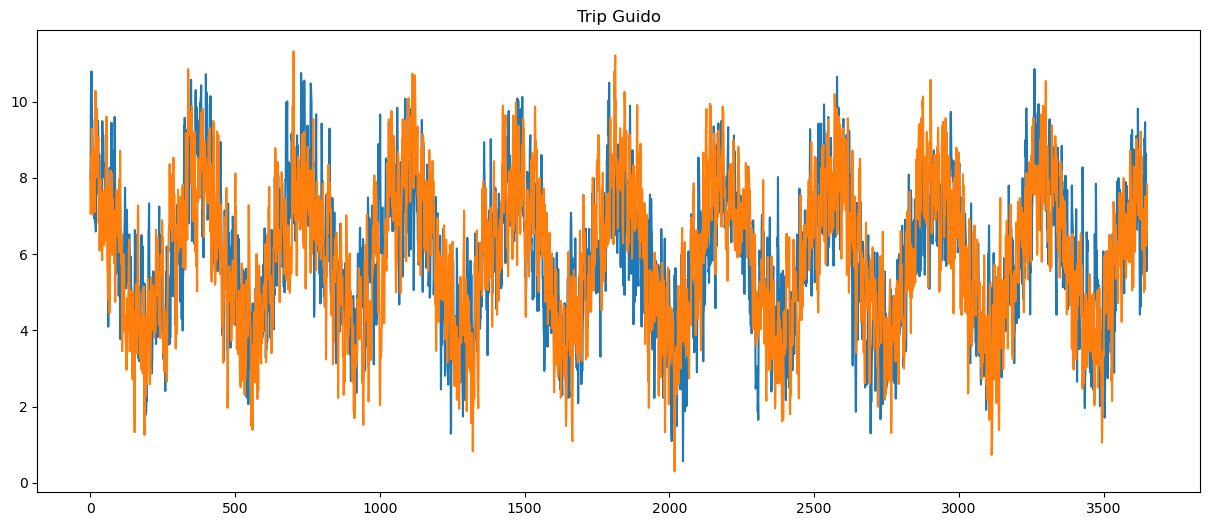

In [48]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 6))

# graficar data
plt.plot(data['regional wind'])
plt.title("Trip Original")
# plt.show()

# graficar modelo predicgo
days = np.arange(0, 365 * YEARS, 1)

print(kappa, sigma)
trip_guido = simulateTrip(days, 109, sigma,S0=8)
# plt.figure(figsize=(15, 6))
plt.plot(trip_guido)
plt.title("Trip Guido")
plt.show()




## Calculamos Beta y Gamma

In [49]:
# new column with the diff between one day and the previous one

data["diff_wind_gap"] = data["wind gap norte sur"].diff().shift(-1)

data.head()

,dia,regional wind,wind gap norte sur,diff_wind,X1,diff_wind_gap
0,1,8.000000,0.000000,0.346296,0.000000,0.181523
1,2,8.346296,0.181523,1.716019,-0.000950,0.007120
2,3,10.062316,0.188643,0.729021,-0.005653,-0.117558
3,4,10.791337,0.071085,-0.037244,-0.007655,0.007358
4,5,10.754093,0.078442,0.017364,-0.007558,0.563745


In [50]:
# Diferencia entre molinos

#Di+1 = Di −βDi∆ + γ√∆ Wi (2)
#Di+1 - Di = βDi∆ + 0 (2)

# Calcular las diferencias Y_i = D_{i+1} - D_i
data['diff_wind_gap'] = data['wind gap norte sur'].diff().shift(-1)

# Calcular X1_i = (-Di) * Δ 
data['X_wind_gap'] = -1 *data["wind gap norte sur"][1:] * DELTA 

# Calcular W_i como el residuo de Y y X1
# Suponiendo que tienes alguna estimación de W_i, si no, deberás calcularla
# W_i es N(0,1) distribuido normalmente, por lo que puedes modelarlo a partir del residuo
# Por simplicidad, puedes asumir que W_i es un vector aleatorio para fines de regresión.

# Crear el modelo de regresión
X_wind_gap = data[['X_wind_gap']][1:-1]
Y_wind_gap = data[['diff_wind_gap']][1:-1]

# Ajustar el modelo de regresión
model = LinearRegression()
model.fit(X_wind_gap, Y_wind_gap)

# Obtener el valor de beta (pendiente)
print(model.coef_)
beta = model.coef_[0][0]


print(f"Valor estimado de beta: {beta}")


[[48.37684938]]
Valor estimado de beta: 48.37684937653269


In [51]:
# Calcular los residuos de la regresión
error_WG = Y_wind_gap - model.predict(X_wind_gap)
var_WG = error.var()
gamma = np.sqrt(var_WG / DELTA)

print(f"Valor estimado de gamma: {gamma}")

Valor estimado de gamma: 16.047720266718766


In [52]:
beta, gamma

(48.37684937653269, 16.047720266718766)

48.37684937653269 16.047720266718766


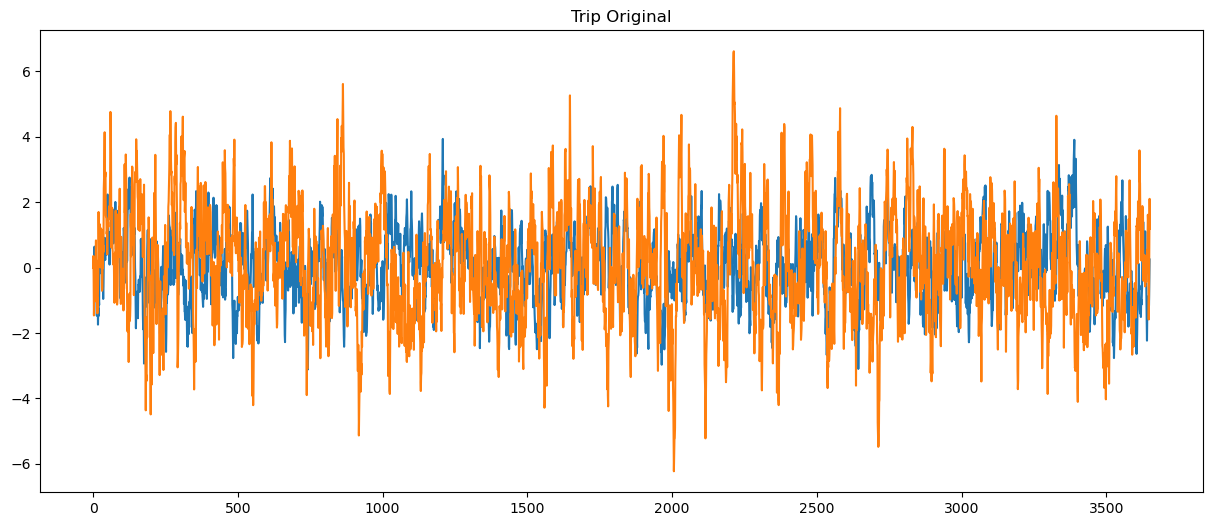

In [53]:
plt.figure(figsize=(15, 6))

# graficar data
plt.plot(data['wind gap norte sur'])
plt.title("Trip Original")
# graficar modelo predicgo
print(beta, gamma)
trip_diff = simulateDiffTrip(beta, gamma)
# print(trip_diff)
# trip_guido = simulateTripNorteSUr(days, beta, gamma,S0=8)
plt.plot(trip_diff)

plt.show()

In [54]:
def theta_i(i):
    num = 6 + 2 * np.cos(2 * np.pi * i / 365)
    return num

In [55]:
def simulacion(kappa, sigma,beta,gamma, dias = N, M = 100):
# m = cantidad de caminos
# simula n dias de los m molinos 
    molinoNorte, molinoSur, diff = np.zeros((M, dias)), np.zeros((M, dias)), np.zeros((M, dias))
    Z,W = np.random.normal(0, 1, (M, dias)), np.random.normal(0, 1, (M, dias))
    
    molinoNorte[:,0] = S0
    diff[:,0] = D0

    for t in range(1, dias):
        molinoNorte[:,t] = molinoNorte[:, t-1] + kappa * (theta_i(np.zeros(M) + t) - molinoNorte[:, t-1]) * DELTA + np.sqrt(DELTA) * Z[:,t] * sigma
        diff[:,t] = diff[:, t-1] - beta * diff[:, t-1] * DELTA + np.sqrt(DELTA) * W[:,t] * gamma
        molinoSur[:,t] = molinoNorte[:,t] + diff[:,t]
    return molinoNorte , molinoSur   

In [56]:
M = 50
simulations = simulacion(kappa, sigma,beta,gamma,dias= N, M=M)

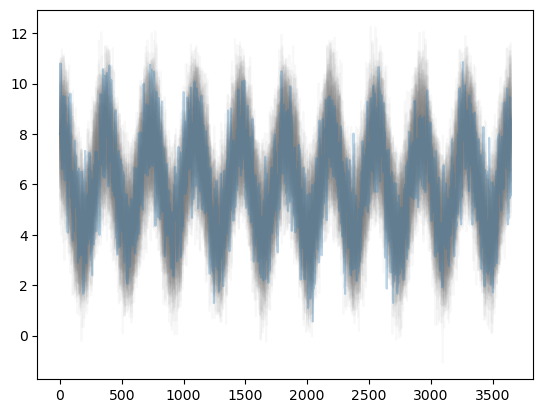

In [57]:
# Plot data: Graficamos los M caminos simulados

# Plot simulation
for i in range(M):
    # color gray and alpha 0.1
    plt.plot(simulations[0][i,:], color='gray', alpha=0.05)
    #plt.plot(simulations[1][i,:], color='red', alpha=0.005)

plt.plot(data['regional wind'], alpha=0.3)

plt.show()

# Formula Ganancia

Con el modelo para el molino de viento ya calibrado, supon ́e que el ingreso diario
generado es 1000 ∗Si d ́olares si el molino est ́a prendido ese d ́ıa (Si es la velocidad
del viento ese d ́ıa en m/seg).

Cada molino est ́a expuesto a sufrir roturas causadas por el viento excesivo. La prob-
abilidad de que el molino se rompa en el d ́ıa i, si estaba activo en el d ́ıa i −1, es
0.25 ∗S(i)2∆. Por ejemplo, si el viento en un d ́ıa en particular es de 10m/seg, la
probabilidad de una falla ese d ́ıa es de 0.068. Si el molino falla un d ́ıa, ese d ́ıa no
estar ́a activo y se arreglar ́a el mismo d ́ıa a un costo de 200 mil d ́olares.

La empresa puede prender y apagar libremente el molino para protegerlo de da ̃nos
y maximizar ingresos siguiendo una regla de umbral fijo. Esto es, cada vez que el
viento supera un umbral K se apagar ́a el molino si estaba prendido. Y cada vez que
el viento descienda a trav ́es del mismo umbral deber ́a prenderse si estaba apagado.

El acto de apagar el molino cuesta 1000 d ́olares cada vez. Prenderlo no cuesta nada.
Queremos maximizar el Valor Actual Neto esperado de la turbina, donde los ingresos
netos son sobre un a ̃no e incorporan la venta de electricidad generada diariamente y
todos los costos mencionados arriba. La tasa de inter ́es es del 5% anual con capital-
izaci ́on diaria (el cashflow en d ́ıa i se descuenta como e−0.05i/365.

### Constantes

In [58]:
# el ingreso diario generado es 1000 ∗ Si dolares si el molino esta prendido ese dia
PRICE = 1000
# La probabilidad de que el molino se rompa en el dia i, si estaba activo en el dia i −1, es 0.25 ∗ S(i)2∆.
BREAK_PROB = 0.25
# Si el molino falla un dıa, ese dia no estara activo y se arreglara el mismo dıa a un costo de 200 mil dolares
BREAK_COST = 200000
# El acto de apagar el molino cuesta 1000 dolares cada vez. Prenderlo no cuesta nada.
TURN_OFF_COST = 1000
TURN_ON_COST = 0
# La tasa de inter ́es es del 5% anual con capitalizacion diaria (el cashflow en dia i se descuenta como e−0.05i/365)
INTEREST_RATE = 0.05


### Funciones Auxiliares

In [59]:
from typing import List
import numpy as np

def p_romperse(S):
    return BREAK_PROB * np.array(S) ** 2 * DELTA

def ingreso(S:List[float], isOn:List[bool]):
    return PRICE * np.array(S) * isOn

def nextStateIsOn(S:List[float], isOn:List[bool],k):
    turn_off_candidate = np.array(S) >= k
    prender = ~np.logical_and(isOn , turn_off_candidate)
    apagar = np.logical_and(isOn , turn_off_candidate)

    costo_prender_total = prender * TURN_ON_COST
    costo_apagar_total = apagar * TURN_OFF_COST

    nextIsOn = ~turn_off_candidate
    
    return nextIsOn, costo_prender_total + costo_apagar_total

def seRompio(S:List[float],isOn:List[bool]):
    return np.logical_and(np.random.uniform(0,1,size=(np.array(S).shape)) < p_romperse(S),isOn)






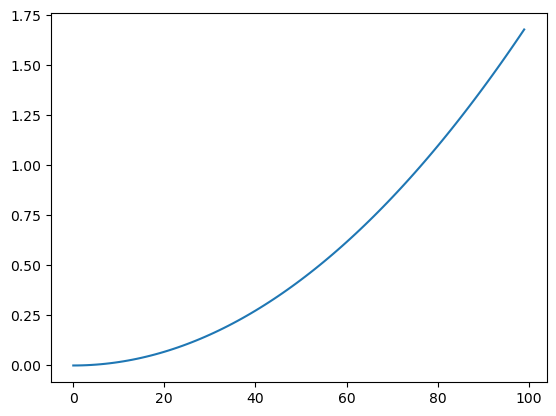

In [60]:
S = np.arange(0,50,0.5)
p = p_romperse(S)

plt.plot(p)
plt.show()

#p.array([1,2,3])**2

In [61]:
# Test Aux Func

s0 = np.array([0,1,2,3,4,5])
isOn = np.array([False,True,True,True,True,True])



isOn,costo = nextStateIsOn(s0, isOn,3)
isOn,costo

(array([ True,  True,  True, False, False, False]),
 array([   0,    0,    0, 1000, 1000, 1000]))

In [62]:
def ganancia(molinoNorte, molinoSur,k):

    isOnNorte = np.zeros(molinoNorte.shape[0]) 
    isOnSur = np.zeros(molinoNorte.shape[0]) 

    gananciaNorte = np.zeros(molinoNorte.shape[0])
    gananciaSur = np.zeros(molinoNorte.shape[0])

    for t in range(molinoNorte.shape[1]):
        gananciaNorte_t = ingreso(molinoNorte[:,t],isOnNorte) - seRompio(molinoNorte[:,t],isOnNorte) * BREAK_COST
        isOnNorte,costosNorte_t = nextStateIsOn(molinoNorte[:,t],isOnNorte,k)
        gananciaNorte += gananciaNorte_t - costosNorte_t

        gananciaSur_t = ingreso(molinoSur[:,t],isOnSur) - seRompio(molinoSur[:,t],isOnSur) * BREAK_COST
        isOnSur,costosSur_t = nextStateIsOn(molinoSur[:,t],isOnSur,k)
        np.append(gananciaSur ,gananciaSur[:,t-1] +  gananciaSur_t - costosSur_t,axis=1)
        
    return gananciaNorte +  gananciaSur

In [63]:
def gananciaV3(molinoNorte, molinoSur,k):

    isOnNorte = np.zeros(molinoNorte.shape[0]) + 1
    isOnSur = np.zeros(molinoNorte.shape[0]) + 1

    gananciaNorte = np.zeros_like(molinoNorte)
    gananciaSur = np.zeros_like(molinoSur)
    

    for t in range(molinoNorte.shape[1]):
        gananciaNorte_t = ingreso(molinoNorte[:,t],isOnNorte) - seRompio(molinoNorte[:,t],isOnNorte) * BREAK_COST
        isOnNorte,costosNorte_t = nextStateIsOn(molinoNorte[:,t],isOnNorte,k)
        gananciaNorte[:,t] = gananciaNorte[:,t-1] +  gananciaNorte_t - costosNorte_t

        gananciaSur_t = ingreso(molinoSur[:,t],isOnSur) - seRompio(molinoSur[:,t],isOnSur) * BREAK_COST
        isOnSur,costosSur_t = nextStateIsOn(molinoSur[:,t],isOnSur,k)
        gananciaSur[:,t] = gananciaSur[:,t-1] +  gananciaSur_t - costosSur_t
        
    return gananciaNorte ,  gananciaSur

In [80]:
def gananciaV4(molinoNorte, molinoSur,k):

    isOnNorte = np.zeros_like(molinoNorte) + 1
    isOnSur = np.zeros_like(molinoNorte) + 1

    gananciaNorte = np.zeros_like(molinoNorte)
    gananciaSur = np.zeros_like(molinoSur)

    roturaNorte = np.zeros_like(molinoNorte)
    roturaSur = np.zeros_like(molinoSur)
    

    for t in range(molinoNorte.shape[1]-1):
        gananciaNorte_t = ingreso(molinoNorte[:,t],isOnNorte[:,t]) - seRompio(molinoNorte[:,t],isOnNorte[:,t]) * BREAK_COST
        roturaNorte[:,t] = seRompio(molinoNorte[:,t],isOnNorte[:,t])
        isOnNorte[:,t+1],costosNorte_t = nextStateIsOn(molinoNorte[:,t],isOnNorte[:,t],k)
        gananciaNorte[:,t] = gananciaNorte[:,t-1] +  gananciaNorte_t - costosNorte_t

        gananciaSur_t = ingreso(molinoSur[:,t],isOnSur[:,t]) - seRompio(molinoSur[:,t],isOnSur[:,t]) * BREAK_COST
        isOnSur[:,t+1],costosSur_t = nextStateIsOn(molinoSur[:,t],isOnSur[:,t],k)
        roturaSur[:,t] = seRompio(molinoSur[:,t],isOnSur[:,t])
        gananciaSur[:,t] = gananciaSur[:,t-1] +  gananciaSur_t - costosSur_t
        
    return gananciaNorte, gananciaSur,isOnNorte,isOnSur, roturaNorte, roturaSur

In [64]:
simulations = simulacion(kappa, sigma,beta,gamma,dias= 365, M=M)
earningNorte,earningSur = gananciaV3(simulations[0],simulations[1],8)


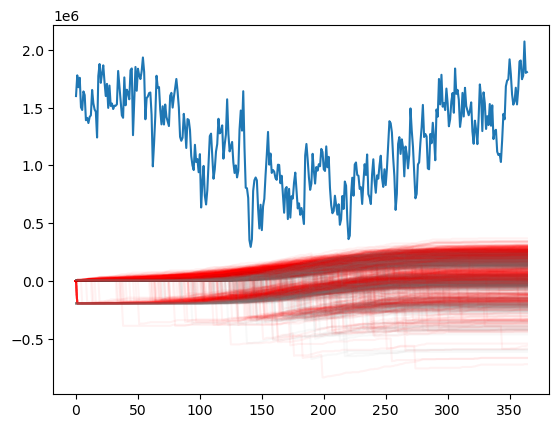

In [108]:
m = 1000
simulations = simulacion(kappa, sigma,beta,gamma,dias= 365, M=m)
earningNorte,earningSur = gananciaV3(simulations[0],simulations[1],4)

# Plot una Ganancia

for i in range(m):
    plt.plot(earningNorte[i,:], color='gray', alpha=0.05)
    plt.plot(earningSur[i,:], color='red', alpha=0.05)

plt.plot(200000*simulations[0][0,:])
plt.show()

In [66]:
#para cada simulacion calculamos el van osea , recorres cada fila hasta el final?
def van(ganancia):
    VAN = np.zeros(ganancia.shape[0])
    for i in range(ganancia.shape[1]):
        VAN += (ganancia[:,i] *(1- np.exp(0.05*i/365))) /(1.05**i)

    return VAN

In [67]:
a = np.array([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]])
van(a)

array([-0.00468145, -0.00468145, -0.00468145, -0.00468145, -0.00468145])

In [114]:
# 5000 = 37 seg
# 10000 = 1 min 15 seg
# k = 15
# earnings = [np.mean([np.mean(ganancia(simulations[0],simulations[1],k)) for i in range(5000)]) for k in np.arange(6,11,0.5)]

In [127]:
# plot earnings





NameError: name 'earnings' is not defined

In [ ]:
k =8
ganancia2 , isOnHistory = gananciaV2(simulations[0],simulations[1],k)

print(isOnHistory[0])

trip = simulations[0]


# Scater plot trip
plt.scatter(range(trip.shape[1]),trip[0,:],c=isOnHistory[0],cmap='coolwarm',alpha=0.5)
# plot threshold k
plt.axhline(k, color='red')

In [ ]:
def gananciaV2(molinoNorte, molinoSur,k):

    isOnNorte = np.zeros_like(molinoNorte)
    isOnNorte[:,0] = 1

    gananciaNorte = np.zeros(molinoNorte.shape[0])

    for t in range(molinoNorte.shape[1]-1):

        #gananciaNorte_t = ingreso(molinoNorte[:,t],isOnNorte[:,t]) - seRompio(molinoNorte[:,t],isOnNorte) * BREAK_COST
        gananciaNorte_t = ingreso(molinoNorte[:,t],isOnNorte[:,t]) - seRompio(molinoNorte[:,t],isOnNorte[:,t]) * BREAK_COST
        nextIsOnNorte,costosNorte_t = nextStateIsOn(molinoNorte[:,t],isOnNorte[:,t],k)
        isOnNorte[:,t+1] = nextIsOnNorte
        gananciaNorte += gananciaNorte_t - costosNorte_t

        
        
    return gananciaNorte ,isOnNorte

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

m = 1000
n = 365 * 2
K = 15
simulations = simulacion(kappa, sigma,beta,gamma,dias= n, M=m)
gananciaNorte, gananciaSur, isOnNorte,isOnSur, roturaNorte, roturaSur = gananciaV4(simulations[0],simulations[1],5)
gananciaNorteI = [[gananciaV4(simulations[0],simulations[1],k)[0],gananciaV4(simulations[0],simulations[1],k)[2]] for k in np.arange(0,K,1)]

gananciaPromedio = [np.mean(gananciaNorteI[k][0][:,-2]) for k in range(len(gananciaNorteI))]

print(gananciaPromedio)
# Plot ganancia (scatter plot)

# Plot una Ganancia
# for i in range(m):
#     plt.plot(gananciaNorte[i,:],color='gray',alpha=0.05)
#     plt.plot(gananciaSur[i,:],color='red',alpha=0.05)

# color dependig if isOn or not
# Scater plot trip



def plot_sine(a):
    plt.figure(figsize=(10,5))

    plt.scatter(range(simulations[0].shape[1]),simulations[0][0,:],c=gananciaNorteI[a][1][0],cmap='coolwarm',alpha=0.5)
    # plot threshold k
    plt.axhline(a, color='red')
    plt.show()
    plt.figure(figsize=(10,5))
    for i in range(m-1):
        # plot text
        plt.text(400, np.mean(gananciaNorteI[a][0][:,-1]), "Ganancia del año: " + str(np.mean(gananciaNorteI[a][0][:,-10])), fontsize=12)
        plt.plot(gananciaNorteI[a][0][i,:],color='gray',alpha=0.1)

    plt.show()

    # plot ganancia promedio
    plt.plot(gananciaPromedio)
    plt.axvline(a, color='red')
    plt.show()

    
# Crear un slider interactivo usando ipywidgets

interact(plot_sine, a=widgets.IntSlider(min=0, max=K-1, step= 1, value=1))


[-1996.521905724974, -981.003396346713, 5611.900216512322, 42871.43730919365, 146015.14001930604, 326870.06809698837, 496199.86732307693, 574599.3744169845, 557340.9680545871, 488935.2476474873, 448536.55817138136, 436440.6176580763, 367100.71507351694, 443548.54410111223, 403561.1445306517]


interactive(children=(IntSlider(value=1, description='a', max=14), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_sine(a)>